## Importing dataset and visualization

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
sys.path.append(os.path.abspath('/'))
from utils import load_keel_dataset
from utils import add_noise, add_label_noise

file_path="KEEL/keel_data/iris.dat"

X_train, X_test, y_train, y_test, label_map = load_keel_dataset(
        train_path=file_path,
        already_split=False
    )

# Ensure labels are adjusted to start from 0
if (min(set(y_train))==1):
    y_train = y_train - 1  
    y_test = y_test - 1  

noise_scale = 0.9
label_noise_range = (0.0,0.5)
X_train_noisy, _, dX, _ = add_noise(X_train, noise_type="gaussian", noise_scale=noise_scale)
y_train_noisy, _, py, _ = add_label_noise(y_train, mode="random_prob", random_seed=29, prob_range=label_noise_range)
print("Head of training data: \n", X_train[:10])
print("Head of noisy training data: \n", X_train_noisy[:10])
print("Head of labels: \n", y_train[:20])
print("Head of noisy labels: \n", y_train_noisy[:20])

Head of training data: 
 [[5.4 3.7 1.5 0.2]
 [4.9 2.5 4.5 1.7]
 [5.5 2.4 3.8 1.1]
 [4.8 3.4 1.6 0.2]
 [5.6 2.7 4.2 1.3]
 [7.7 2.6 6.9 2.3]
 [5.7 2.8 4.1 1.3]
 [6.  3.  4.8 1.8]
 [6.7 3.1 5.6 2.4]
 [5.6 2.8 4.9 2. ]]
Head of noisy training data: 
 [[ 5.94610913  3.78945346  0.53827962 -0.52881872]
 [ 6.09694604  2.37404895  4.02785742  1.48935492]
 [ 5.26826586  2.27882371  2.86447786  1.43178083]
 [ 4.99092638  3.30083253  2.24480313 -0.67758714]
 [ 6.00990451  2.07750846  5.43923488  0.65237642]
 [ 7.53347482  3.00818945 11.30785061  2.16013568]
 [ 5.77956765  2.90834972  2.65481424  2.40424166]
 [ 6.43196391  3.05105544  6.50842737  0.97001266]
 [ 7.73148275  3.11349174  5.56465558  2.98705799]
 [ 4.11506278  2.94742602  8.00095625  2.7327037 ]]
Head of labels: 
 [0 2 1 0 1 2 1 2 2 2 2 1 1 1 1 0 0 2 2 0]
Head of noisy labels: 
 [0 2 1 0 1 1 1 2 2 2 2 2 1 1 0 2 0 2 1 2]


#### Visualization

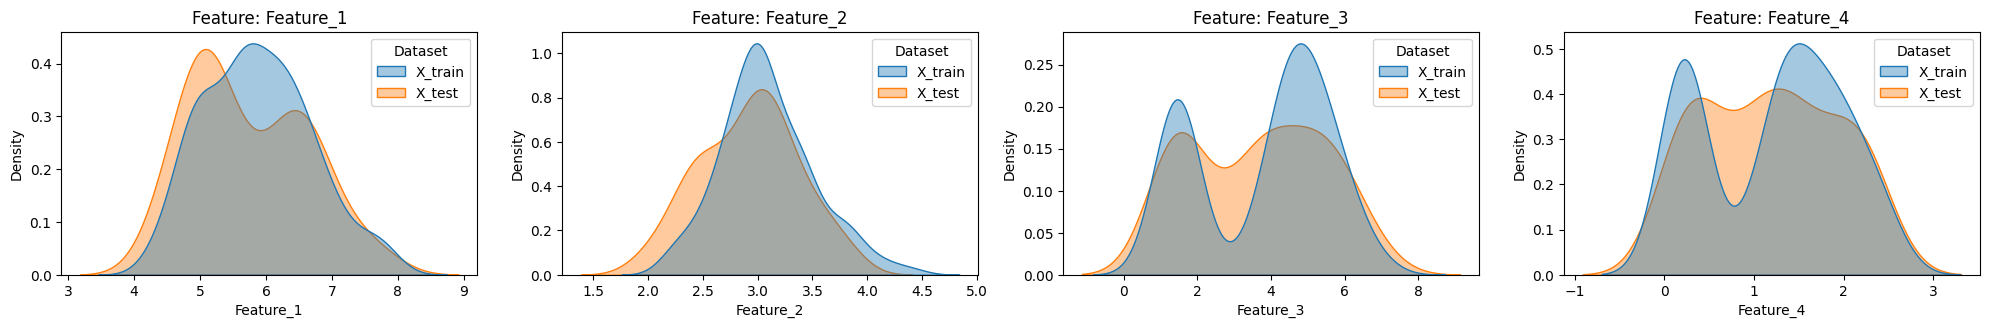

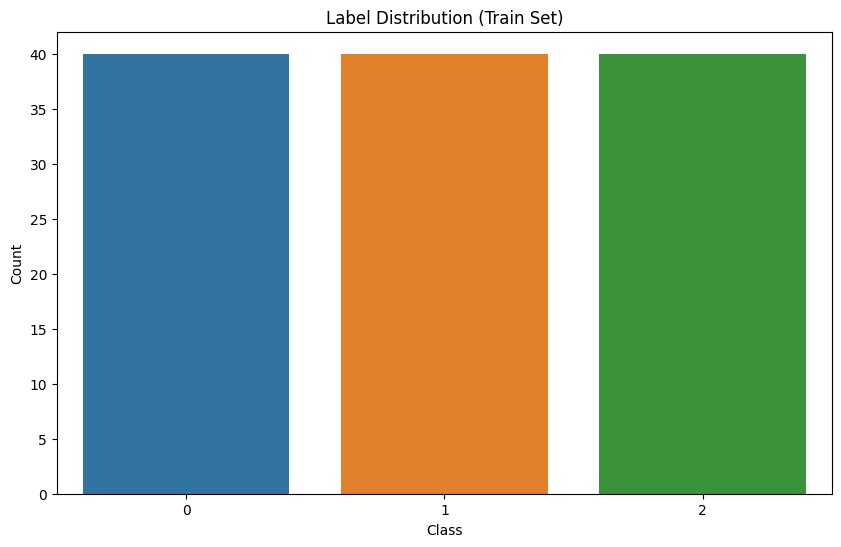

In [10]:
feature_names_train = [f'Feature_{i+1}' for i in range(X_train.shape[1])]

df1 = pd.DataFrame(X_train, columns=feature_names_train)
df1['Label'] = y_train
df1['Dataset'] = 'X_train'

feature_names_test = [f'Feature_{i+1}' for i in range(X_test.shape[1])]

df2 = pd.DataFrame(X_test, columns=feature_names_test)
df2['Label'] = y_test       # <-- Fix here: assign y_test to df2, not df1
df2['Dataset'] = 'X_test'

# Combine both train and test dataframes for plotting
df_all = pd.concat([df1, df2], ignore_index=True)

# Plot distributions of each feature side by side
plt.figure(figsize=(20, 15))
for i, feature in enumerate(feature_names_train):
    plt.subplot(5, 4, i + 1)
    sns.kdeplot(data=df_all, x=feature, hue='Dataset', common_norm=False, fill=True, alpha=0.4, bw_adjust=0.9)
    plt.title(f"Feature: {feature}")
plt.tight_layout()
plt.show()



# Plot label distribution (only for training set or combined if you want)
plt.figure(figsize=(10, 6))
sns.countplot(x='Label', data=df1, order=sorted(df1['Label'].unique()))
plt.title("Label Distribution (Train Set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

#### Visualizing noise

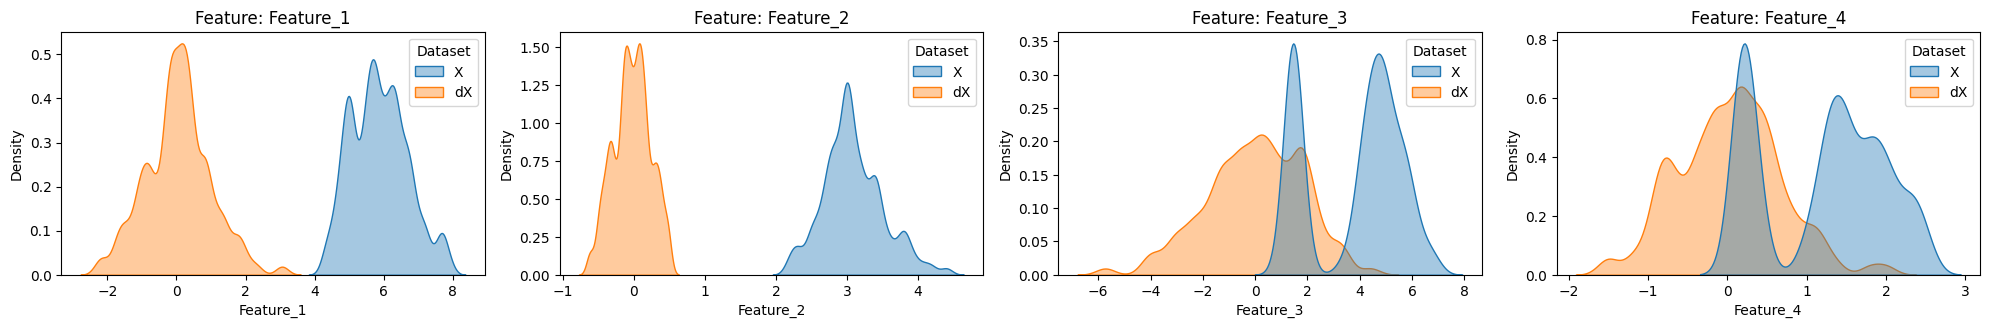

In [6]:
feature_names = [f'Feature_{i+1}' for i in range(X_train.shape[1])]

df1 = pd.DataFrame(X_train, columns=feature_names)
df1['Label'] = y_train
df1['Dataset'] = 'X'

df2 = pd.DataFrame(dX, columns=feature_names)
df2['Dataset'] = 'dX'

# Combine both for easier plotting
df_all = pd.concat([df1, df2], ignore_index=True)

# Plot distributions of each feature side by side
plt.figure(figsize=(20, 15))
for i, feature in enumerate(feature_names):
    plt.subplot(5, 4, i + 1)
    sns.kdeplot(data=df_all, x=feature, hue='Dataset', common_norm=False, fill=True, alpha=0.4, bw_adjust=0.5)
    plt.title(f"Feature: {feature}")
plt.tight_layout()
plt.show()

## Setting Seeds

In [7]:
import numpy as np
import random
import tensorflow as tf
import os

def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

SEEDS = [27, 272, 2727, 1, 30, 50]


## Probabilistic Deep Forest (PDF)

In [13]:
import PRF4DF
import probabilistic_deep_forest as pdf
from sklearn.metrics import accuracy_score

n_cascade_estimators = 4
n_classes = len(label_map)
n_features = X_train.shape[1]

accuracies_PDRF = []

for seed in SEEDS:
    set_all_seeds(seed)

    model = pdf.CascadeForestClassifier(
        random_state=seed, n_jobs=-1,
    )
    prf_estimators = []
    for i in range(n_cascade_estimators):
        estimator = PRF4DF.SklearnCompatiblePRF(
            n_classes_=n_classes,
            n_features_=n_features,
            n_estimators=20,
            max_depth=4,
            n_jobs=1
        )
        prf_estimators.append(estimator)

    model.set_estimator(prf_estimators)
    model.fit(X=X_train_noisy, y=y_train_noisy)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    accuracies_PDRF.append(acc)

mean_acc = np.mean(accuracies_PDRF)
std_acc = np.std(accuracies_PDRF)
print(f"PDRF Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


[2025-06-12 21:32:42.682] Start to fit the model:
[2025-06-12 21:32:42.682] Fitting cascade layer = 0 
[2025-06-12 21:32:46.641] layer = 0  | Val Acc = 47.500 % | Elapsed = 3.959 s
[2025-06-12 21:32:46.641] Fitting cascade layer = 1 
[2025-06-12 21:32:47.824] layer = 1  | Val Acc = 52.500 % | Elapsed = 1.183 s
[2025-06-12 21:32:47.824] Fitting cascade layer = 2 
[2025-06-12 21:32:48.872] layer = 2  | Val Acc = 47.500 % | Elapsed = 1.048 s
[2025-06-12 21:32:48.872] Early stopping counter: 1 out of 2
[2025-06-12 21:32:48.872] Fitting cascade layer = 3 
[2025-06-12 21:32:49.907] layer = 3  | Val Acc = 47.500 % | Elapsed = 1.035 s
[2025-06-12 21:32:49.907] Early stopping counter: 2 out of 2
[2025-06-12 21:32:49.907] Handling early stopping
[2025-06-12 21:32:49.907] The optimal number of layers: 2
[2025-06-12 21:32:49.912] Start to evalute the model:
[2025-06-12 21:32:49.924] Evaluating cascade layer = 1 
[2025-06-12 21:32:49.945] Start to fit the model:
[2025-06-12 21:32:49.945] Fitting ca

## Other Classifiers

#### Probabilistic Random Forest (PRF)

In [14]:
import PRF

accuracies_PRF = []

for seed in SEEDS:
    set_all_seeds(seed)
    prf_cls = PRF.prf(n_estimators=200, bootstrap=True)
    prf_cls.fit(X=X_train_noisy, py=py, dX=dX)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_pred, y_test)
    accuracies_PRF.append(acc)

mean_acc = np.mean(accuracies_PRF)
std_acc = np.std(accuracies_PRF)
print(f"PRF Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


[2025-06-12 21:33:22.740] Start to evalute the model:
[2025-06-12 21:33:23.790] Start to evalute the model:
[2025-06-12 21:33:24.926] Start to evalute the model:
[2025-06-12 21:33:25.996] Start to evalute the model:
[2025-06-12 21:33:27.092] Start to evalute the model:
[2025-06-12 21:33:28.181] Start to evalute the model:
PRF Accuracy: 0.8000 ± 0.0000


#### Random Forest (RF)

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

accuracies_RF = []

for seed in SEEDS:
    set_all_seeds(seed)
    rf = RandomForestClassifier(n_estimators=200, random_state=seed)
    rf.fit(X_train_noisy, y_train_noisy)
    y_pred = rf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies_RF.append(acc)

mean_acc = np.mean(accuracies_RF)
std_acc = np.std(accuracies_RF)
print(f"Random Forest Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


Random Forest Accuracy: 0.7722 ± 0.0299


#### Deep Forest (DF)

In [16]:
from deepforest import CascadeForestClassifier
from sklearn.metrics import accuracy_score

accuracies_DF = []

for seed in SEEDS:
    set_all_seeds(seed)
    clf = CascadeForestClassifier(n_estimators=2, random_state=seed, n_trees=10)
    clf.fit(X_train_noisy, y_train_noisy)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies_DF.append(acc)

mean_acc = np.mean(accuracies_DF)
std_acc = np.std(accuracies_DF)
print(f"Deep Forest Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


[2025-06-12 21:34:48.785] Start to fit the model:
[2025-06-12 21:34:48.786] Fitting cascade layer = 0 
[2025-06-12 21:34:48.822] layer = 0  | Val Acc = 42.500 % | Elapsed = 0.036 s
[2025-06-12 21:34:48.822] Fitting cascade layer = 1 
[2025-06-12 21:34:48.851] layer = 1  | Val Acc = 50.833 % | Elapsed = 0.029 s
[2025-06-12 21:34:48.851] Fitting cascade layer = 2 
[2025-06-12 21:34:48.884] layer = 2  | Val Acc = 45.833 % | Elapsed = 0.033 s
[2025-06-12 21:34:48.884] Early stopping counter: 1 out of 2
[2025-06-12 21:34:48.884] Fitting cascade layer = 3 
[2025-06-12 21:34:48.914] layer = 3  | Val Acc = 47.500 % | Elapsed = 0.030 s
[2025-06-12 21:34:48.914] Early stopping counter: 2 out of 2
[2025-06-12 21:34:48.914] Handling early stopping
[2025-06-12 21:34:48.914] The optimal number of layers: 2
[2025-06-12 21:34:48.915] Start to evalute the model:
[2025-06-12 21:34:48.915] Evaluating cascade layer = 0 
[2025-06-12 21:34:48.916] Evaluating cascade layer = 1 
[2025-06-12 21:34:48.918] Star

c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\fores

[2025-06-12 21:34:49.006] layer = 2  | Val Acc = 49.167 % | Elapsed = 0.030 s
[2025-06-12 21:34:49.006] Fitting cascade layer = 3 
[2025-06-12 21:34:49.041] layer = 3  | Val Acc = 47.500 % | Elapsed = 0.035 s
[2025-06-12 21:34:49.041] Early stopping counter: 1 out of 2
[2025-06-12 21:34:49.041] Fitting cascade layer = 4 
[2025-06-12 21:34:49.072] layer = 4  | Val Acc = 46.667 % | Elapsed = 0.031 s
[2025-06-12 21:34:49.072] Early stopping counter: 2 out of 2
[2025-06-12 21:34:49.072] Handling early stopping
[2025-06-12 21:34:49.072] The optimal number of layers: 3
[2025-06-12 21:34:49.073] Start to evalute the model:
[2025-06-12 21:34:49.073] Evaluating cascade layer = 0 
[2025-06-12 21:34:49.074] Evaluating cascade layer = 1 
[2025-06-12 21:34:49.075] Evaluating cascade layer = 2 
[2025-06-12 21:34:49.077] Start to fit the model:
[2025-06-12 21:34:49.077] Fitting cascade layer = 0 
[2025-06-12 21:34:49.104] layer = 0  | Val Acc = 50.000 % | Elapsed = 0.027 s
[2025-06-12 21:34:49.104] F

c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\fores

[2025-06-12 21:34:49.226] layer = 1  | Val Acc = 39.167 % | Elapsed = 0.029 s
[2025-06-12 21:34:49.226] Early stopping counter: 1 out of 2
[2025-06-12 21:34:49.226] Fitting cascade layer = 2 
[2025-06-12 21:34:49.260] layer = 2  | Val Acc = 42.500 % | Elapsed = 0.034 s
[2025-06-12 21:34:49.260] Early stopping counter: 2 out of 2
[2025-06-12 21:34:49.260] Handling early stopping
[2025-06-12 21:34:49.260] The optimal number of layers: 1
[2025-06-12 21:34:49.261] Start to evalute the model:
[2025-06-12 21:34:49.261] Evaluating cascade layer = 0 
[2025-06-12 21:34:49.262] Start to fit the model:
[2025-06-12 21:34:49.263] Fitting cascade layer = 0 
[2025-06-12 21:34:49.288] layer = 0  | Val Acc = 46.667 % | Elapsed = 0.025 s
[2025-06-12 21:34:49.288] Fitting cascade layer = 1 
[2025-06-12 21:34:49.321] layer = 1  | Val Acc = 45.000 % | Elapsed = 0.033 s
[2025-06-12 21:34:49.321] Early stopping counter: 1 out of 2
[2025-06-12 21:34:49.321] Fitting cascade layer = 2 
[2025-06-12 21:34:49.352]

c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\fores

[2025-06-12 21:34:49.461] layer = 0  | Val Acc = 48.333 % | Elapsed = 0.039 s
[2025-06-12 21:34:49.462] Fitting cascade layer = 1 
[2025-06-12 21:34:49.494] layer = 1  | Val Acc = 45.833 % | Elapsed = 0.032 s
[2025-06-12 21:34:49.494] Early stopping counter: 1 out of 2
[2025-06-12 21:34:49.494] Fitting cascade layer = 2 
[2025-06-12 21:34:49.524] layer = 2  | Val Acc = 48.333 % | Elapsed = 0.030 s
[2025-06-12 21:34:49.524] Early stopping counter: 2 out of 2
[2025-06-12 21:34:49.524] Handling early stopping
[2025-06-12 21:34:49.524] The optimal number of layers: 1
[2025-06-12 21:34:49.524] Start to evalute the model:
[2025-06-12 21:34:49.524] Evaluating cascade layer = 0 
Deep Forest Accuracy: 0.7333 ± 0.0816


c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:497: UserWarning: Some inputs do not have OOB predictions. This probably means too few trees were used to compute any reliable oob predictions.
  "Some inputs do not have OOB predictions. "
c:\Users\carlo\Desktop\project\PML\venv\lib\site-packages\deepforest\forest.py:504: RuntimeWarning: invalid value encountered in true_divide
  / oob_decision_function.sum(axis=1)[:, np.newaxis]


#### Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # CPU only

accuracies_NN = []

unique_classes = np.unique(y_train)
num_classes = len(unique_classes)
is_binary = num_classes == 2

if not is_binary:
    y_train_cat = to_categorical(np.searchsorted(unique_classes, y_train_noisy))
    y_test_cat = to_categorical(np.searchsorted(unique_classes, y_test))
else:
    y_train_cat = y_train_noisy
    y_test_cat = y_test

def create_model(hidden_units=64, dropout_rate=0.5, optimizer='adam'):
    model = Sequential()
    model.add(Dense(hidden_units, input_shape=(X_train.shape[1],), activation='relu'))
    model.add(Dropout(dropout_rate))
    if is_binary:
        model.add(Dense(1, activation='sigmoid'))
        model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

for seed in SEEDS:
    set_all_seeds(seed)
    
    model = KerasClassifier(model=create_model, hidden_units=64, dropout_rate=0.5,
                            optimizer='adam', epochs=30, batch_size=16, verbose=0)
    
    model.fit(X_train_noisy, y_train_cat)

    if is_binary:
        y_pred = model.predict(X_test)
        y_true = y_test
    else:
        y_pred = np.argmax(model.predict_proba(X_test), axis=1)
        y_true = np.searchsorted(unique_classes, y_test)

    acc = accuracy_score(y_true, y_pred)
    accuracies_NN.append(acc)

mean_acc = np.mean(accuracies_NN)
std_acc = np.std(accuracies_NN)
print(f"Neural Network Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


Neural Network Accuracy: 0.6833 ± 0.0500


#### Kernel SVM

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

accuracies_KSVM = []

# Using seed for reproducibility
set_all_seeds(SEEDS[0])

# Model and parameter grid
model = SVC()
param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# Performing GridSearchCV once
grid = GridSearchCV(model, param_grid, cv=3, n_jobs=1)
grid.fit(X_train_noisy, y_train_noisy)

# Get best model
best_svm = grid.best_estimator_

# Predict and evaluate
y_pred = best_svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)

accuracies_KSVM = [acc] * len(SEEDS)

mean_acc = np.mean(accuracies_KSVM)
std_acc = np.std(accuracies_KSVM)
print(f"Kernel SVM Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")


Kernel SVM Accuracy: 0.8333 ± 0.0000


## Results Comparison

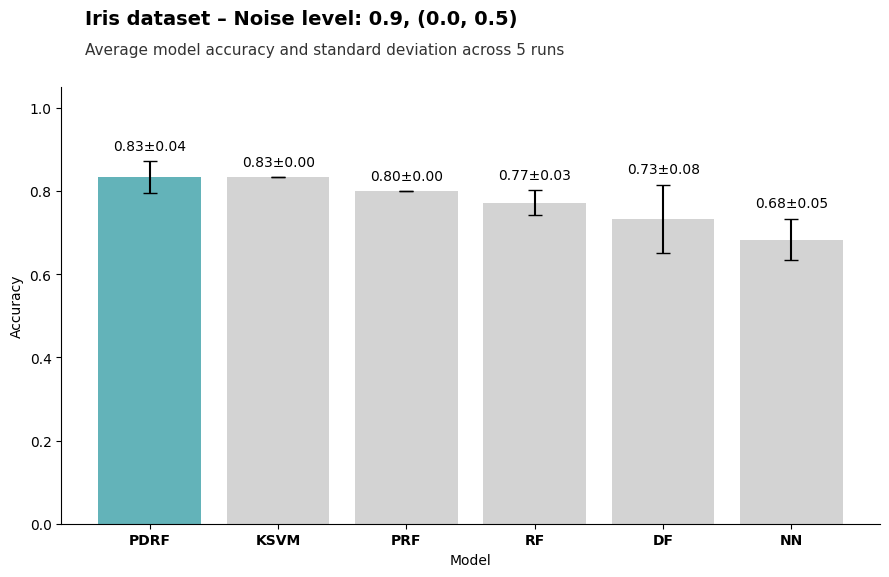

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

# Building df for comparison
comparison_df = pd.DataFrame({
    "Model": ["PDRF", "PRF", "DF", "RF", "NN", "KSVM"],
    "Mean Accuracy": [
        np.mean(accuracies_PDRF),
        np.mean(accuracies_PRF),
        np.mean(accuracies_DF),
        np.mean(accuracies_RF),
        np.mean(accuracies_NN),
        np.mean(accuracies_KSVM),
    ],
    "Std": [
        np.std(accuracies_PDRF),
        np.std(accuracies_PRF),
        np.std(accuracies_DF),
        np.std(accuracies_RF),
        np.std(accuracies_NN),
        np.std(accuracies_KSVM),
    ]
})


comparison_df = comparison_df.sort_values("Mean Accuracy", ascending=False)

def get_color(model):
    return "#55bfc7" if model == "PDRF" else "lightgray"
colors = comparison_df["Model"].apply(get_color)

# Extracting base name from file path
base_name = os.path.splitext(os.path.basename(file_path))[0]  # e.g., "phoneme"
title_name = base_name.replace('_', ' ').title()              # e.g., "Phoneme"

# Output path
output_dir = "../results/1_low_noise/plots/"
os.makedirs(output_dir, exist_ok=True)
output_filename = os.path.join(output_dir, f"{base_name}_low_noise.png")


# 5. Create the plot
fig, ax = plt.subplots(figsize=(9, 6))

sns.barplot(
    data=comparison_df,
    x="Model",
    y="Mean Accuracy",
    palette=colors,
    errorbar=None,
    ax=ax
)

# Error bars added manually
x_positions = range(len(comparison_df))
means = comparison_df["Mean Accuracy"].values
stds = comparison_df["Std"].values
ax.errorbar(
    x=x_positions,
    y=means,
    yerr=stds,
    fmt='none',
    ecolor='black',
    elinewidth=1.5,
    capsize=5
)

ax.set_ylabel("Accuracy")
ax.set_xlabel("Model")
ax.set_ylim(0, 1.05)
sns.despine()

# Annotation above error bars
for x, (mean, std) in enumerate(zip(means, stds)):
    ax.text(
        x, mean + std + 0.02,
        f'{mean:.2f}±{std:.2f}',
        ha='center', va='bottom',
        fontsize=10, color='black'
    )

ax.set_xticklabels(ax.get_xticklabels(), fontweight='bold')

fig.text(
    0.1, 0.93,
    f"{title_name} dataset – Noise level: {noise_scale}, {label_noise_range}",
    ha='left',
    fontsize=14,
    fontweight='bold'
)
fig.text(
    0.1, 0.88,
    "Average model accuracy and standard deviation across 5 runs",
    ha='left',
    fontsize=11, color = "#333333"
)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.savefig(output_filename, dpi=300, bbox_inches='tight')
plt.show()


#### Saving results

In [22]:
results_df = pd.DataFrame({
    "Model": ["PDRF", "PRF", "DF", "RF", "NN", "KSVM"],
    "Mean Accuracy": [
        np.mean(accuracies_PDRF),
        np.mean(accuracies_PRF),
        np.mean(accuracies_DF),
        np.mean(accuracies_RF),
        np.mean(accuracies_NN),
        np.mean(accuracies_KSVM),
    ],
    "Std": [
        np.std(accuracies_PDRF),
        np.std(accuracies_PRF),
        np.std(accuracies_DF),
        np.std(accuracies_RF),
        np.std(accuracies_NN),
        np.std(accuracies_KSVM),
    ],
    "Seeds": [SEEDS] * 6
})

# results_df.to_csv("../results/1_low_noise/tables/"+f"{base_name}_low_noise.csv", index=False)
# print("Saved to results/1_low_noise/tables/"+f"{base_name}_low_noise.csv")
